In [1]:
#Fgure 11 -13 - Appendix

In [2]:
# Section 5 Alternative Benchmark 
#Calibration 1
#Each firm receives a number of balls in proportion to it's sales at the destination. The balls are distributed across HS-category grid. 
# The probability that a ball lands in a country-HS group cell is given by the product of share of sales that belong to 
# an HS-category 
# The final plots include the mena sales of the best-seeling/least sales and simple averages as a function of product
#scope in the data and predicted by the alternative benchmark

In [3]:
#Download and install the joblib library from the Python Package Index (PyPI)

In [4]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Imports the NumPy library and aliases it as 'np'.
import numpy as np

# Imports the pandas library and aliases it as 'pd'. 
import pandas as pd

# Imports the 'Parallel' and 'delayed' functions from the joblib library. Joblib is a set of tools to provide 
# lightweight pipelining in Python. 'Parallel' is used to execute functions in parallel, while 'delayed' is a 
# simple decorator to capture the arguments of a function. This setup is useful for parallel processing.
from joblib import Parallel, delayed

# Imports the pyplot interface of the matplotlib library as 'plt'. 
import matplotlib.pyplot as plt

#to check the number of cores availiable on the PC download 
from multiprocessing import cpu_count

In [6]:
shipment_size=84608.4
#84608.4  average shipment size between  China and the US
#47542.06   average shipment size overall
#51140.41  average shipment size for shipments >250 between the US and China

In [7]:
# Load the files with the number of balls per firm, share of each HS code in total sales, HScodes

In [8]:
# Sales in each HS category 

# Define the path to the CSV file containing sales data using a relative path.
path_shares_values = r'..\Data-python\HS_shares.csv'
# Load the sales shares data from the specified path. The data is expected to be tab-delimited.
hs_shares = np.genfromtxt(path_shares_values, delimiter='\t')

# Define the path to the CSV file containing HS codes using a relative path.
path_codes_values = r'..\Data-python\HS_codes.csv'
# Load the HS codes data from the specified path. The data is also expected to be tab-delimited.
Hscodes = np.genfromtxt(path_codes_values, delimiter='\t')

# Convert the loaded HS shares data from a NumPy array to a Python list for easier manipulation.
hs_shares = hs_shares.tolist()
# Reshape the HS codes data into a column vector to ensure it has a consistent structure for analysis.
# The '-1' in reshape(-1, 1) indicates that the number of rows should be inferred from the length of the array, 
# making it a single column with as many rows as necessary.
Hscodes = Hscodes.reshape(-1, 1)

# Calculate the total sum sales across all HS categories 
total_sum = sum(hs_shares)
# Divide sales in an HS-category by total sales
hs_shares = [share / total_sum for share in hs_shares]

# Print the sum of all elements in the normalized hs_shares list to verify that it equals 1 after normalization.
print("The sum of all elements in the hs_shares is:", sum(hs_shares))


The sum of all elements in the hs_shares is: 0.9999999999999996


In [9]:
# Load the Balls data from a CSV file located in a relative path '../Data/Balls_All.csv'.
# The data is expected to be tab-delimited ('\t'), which is specified by the delimiter parameter.
Balls = np.genfromtxt(r'..\Data-python\Balls_US.csv', delimiter='\t')

# Normalize the loaded Balls data by dividing firm sales by 'shipment_size'.
Balls = Balls / shipment_size

# Round up each value in the Balls array to the nearest whole number.
# This is done to ensure the count of balls is represented as whole numbers,
# as partial balls are not meaningful in this context.
Balls = np.ceil(Balls)

In [10]:
# Load data on product ranks and average sales at rank
path=r'..\Data-python\RankProductData10.csv'
Rank_df = pd.read_csv(path, encoding='utf-8', header=0)


In [11]:
#Set up a function to allocate a ball across HS-categories

In [12]:
#This function simulates the allocation of balls across different HScodes and associates each allocation with an identifier (i). 
#The final output is a matrix where each row contains the identifier, the HS code, and the number of balls allocated 
#to that HS code, based on the simulated multinomial distribution.

def process_ball(i, ball):
    
    product = np.random.multinomial(ball, hs_shares, size=1)
    id = i * np.ones(len(hs_shares))
    id = id.reshape(-1, 1)
    stacked_matrix = np.hstack((id, Hscodes))
    iter = np.array(product[0])
    iter = iter.reshape(-1, 1)
    return np.hstack((stacked_matrix, iter))

In [13]:
# Use joblib to parallelize the loop to evalutate process_ball function for every element in Balls

#num_cores = cpu_count()-1  # use all available cores

# Adjust the number of cores to stay within Windows' limits.Here we ensure not to exceed 60 (to leave some room for other
#processes and avoid hitting the 64 limit) Note that this machine has 64 cores, in case your machine has fewer cores, 
#the maximum number of cores availiable to joblib maybe smaller

num_cores = min(cpu_count() - 1, 60)

results = Parallel(n_jobs=num_cores)(delayed(process_ball)(i, ball) for i, ball in enumerate(Balls, 1))

# Combine the results into a matrix with 
matrix = np.vstack(results)


In [14]:
# Create a DataFrame 'df' from the variable 'matrix', specifying column names as 'Firm', 'Hscodes', and 'Balls'.
df = pd.DataFrame(data=matrix, columns=['Firm', 'Hscodes', 'Balls'])

# Filter out rows where the value in the 'Balls' column is not equal to 0, effectively removing entries without balls.
df = df[df['Balls'] != 0]

# Create a new column 'nprod_b' that counts the number of products each firm has.
df['nprod_b'] = df.groupby('Firm')['Firm'].transform('count')

# Create a new column 'Sales' by multiplying the 'Balls' column by a predefined value 'shipment_size'.
df['Sales'] = df['Balls'] * shipment_size

# Add a new column 'R', which ranks the sales within each firm in descending order. If two products have the same sales,
# the one that appears first in the DataFrame is given the higher rank. This is achieved by grouping by 'Firm', 
# then using the 'rank' method on the 'Sales' column with 'ascending=False' to ensure a descending order, 
# and 'method='first'' to handle ties by their order in the dataset.
df['R'] = df.groupby(['Firm'])['Sales'].rank(ascending=False, method='first')

# The modified DataFrame 'df' is now returned or ready for use, containing the original data with the additions of
# 'nprod_b' (count of products per firm), 'Sales' (calculated sales figures), and 'R' (rank of sales within each firm).
df


,Firm,Hscodes,Balls,nprod_b,Sales,R
3754,1.0,847160.0,1.0,1,84608.4,1.0
8343,2.0,847330.0,1.0,2,84608.4,1.0
8443,2.0,850440.0,1.0,2,84608.4,2.0
9286,3.0,50510.0,1.0,56,84608.4,8.0
9363,3.0,80232.0,1.0,56,84608.4,9.0
...,...,...,...,...,...,...
153019523,33425.0,940169.0,1.0,20,84608.4,19.0
153019587,33425.0,950662.0,1.0,20,84608.4,20.0
153023404,33426.0,847160.0,1.0,3,84608.4,1.0
153023579,33426.0,851660.0,1.0,3,84608.4,2.0


In [15]:
# Filter only the besst/least selling products
df1=df[(df['nprod_b'] == df['R']) | (df['R'] == 1)]

In [16]:
# Add a new column 'lnSales_bb' which contains the natural logarithm of the 'Sales' column.
df1['lnSales_bb'] = np.log(df1['Sales'])

<ipython-input-16-aaf6890a7adf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['lnSales_bb'] = np.log(df1['Sales'])


In [17]:
# Update the 'nprod_b' column in 'df1' by setting 'nprod_b' that are 10 or greater to 10
df1.loc[df1['nprod_b'] >= 10, 'nprod_b'] = 10


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [18]:
# Update the 'nprod_b' column in 'df1' by setting 'R' that are  less than 10 or greater to 10
df1.loc[df1['R']>10,'R']=10

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [19]:
#Create a new dataframe that calculates average sales for each possible value of rank and nprod variables
agg_df = df1.groupby(['R', 'nprod_b']).agg({'lnSales_bb': 'mean'}).reset_index()

#Rename 'nprod' 'nprod_b'
agg_df = agg_df.rename(columns={'nprod_b': 'nprod'})


In [20]:
#Rename 'l_Sales' 'lnSales'
Rank_df = Rank_df.rename(columns={'l_Sales': 'lnSales'})

In [21]:
#Plot mean sales of best-selling products as a function of scope

In [22]:
# Select best-selling products for plotting
subset1 = Rank_df[Rank_df['R'] == 1]
subset2 = agg_df[agg_df['R'] == 1]

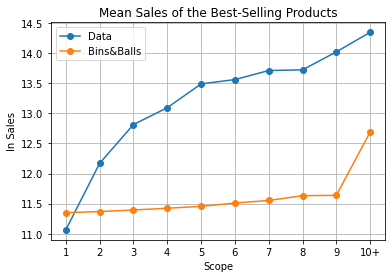

In [23]:
# Plot l_sales and lnSales_bb with nprod as x-axis
plt.plot(subset1['nprod'], subset1['l_sales'], label='Data', marker='o')
plt.plot(subset2['nprod'], subset2['lnSales_bb'], label='Bins&Balls', marker='o')

plt.xlabel('Scope')
plt.ylabel('ln Sales')
   
plt.title('Mean Sales of the Best-Selling Products')
plt.legend()
plt.grid(True)

# Determine the range for x-axis ticks based on your data
max_nprod = max(subset1['nprod'].max(), subset2['nprod'].max())
xticks = range(1, int(max_nprod) + 1)

# Set x-axis ticks to be centered at integers 1, 2, 3, 4, ...
plt.xticks(ticks=xticks)

# Replace the last tick label with '10+' if applicable
xtick_labels = [str(tick) for tick in xticks]
if xtick_labels[-1] == '10':  # Only replace if the last label is '10'
    xtick_labels[-1] = '10+'
plt.xticks(ticks=xticks, labels=xtick_labels)
    
# Save the plot to a PDF file
path = r'..\Includes-python'
plt.savefig(path+'\AppendixFig13.pdf', format='pdf')

plt.show()

In [24]:
#Plot mean sales of least-selling products as a function of scope

In [25]:
# Select best-selling products for plotting
subset1 = Rank_df[Rank_df['R'] == Rank_df['nprod']]
subset2 = agg_df[agg_df['R'] == agg_df['nprod']]


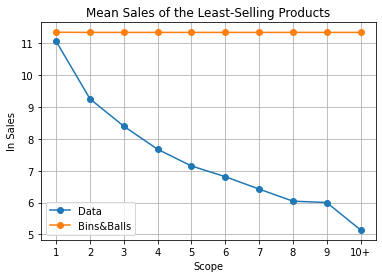

In [26]:
# Plot l_sales and lnSales_bb with nprod as x-axis
plt.plot(subset1['nprod'], subset1['l_sales'], label='Data', marker='o')
plt.plot(subset2['nprod'], subset2['lnSales_bb'], label='Bins&Balls', marker='o')

plt.xlabel('Scope')
plt.ylabel('ln Sales')
   
plt.title('Mean Sales of the Least-Selling Products')
plt.legend()
plt.grid(True)

# Determine the range for x-axis ticks based on your data
max_nprod = max(subset1['nprod'].max(), subset2['nprod'].max())
xticks = range(1, int(max_nprod) + 1)

# Set x-axis ticks to be centered at integers 1, 2, 3, 4, ...
plt.xticks(ticks=xticks)

# Replace the last tick label with '10+' if applicable
xtick_labels = [str(tick) for tick in xticks]
if xtick_labels[-1] == '10':  # Only replace if the last label is '10'
    xtick_labels[-1] = '10+'
plt.xticks(ticks=xticks, labels=xtick_labels)


# Save the plot to a PDF file
path = r'..\Includes-python'
plt.savefig(path+'\AppendixFig14.pdf', format='pdf')

plt.show()

In [27]:
#Plot average sales as a function of scope

In [28]:
df

,Firm,Hscodes,Balls,nprod_b,Sales,R
3754,1.0,847160.0,1.0,1,84608.4,1.0
8343,2.0,847330.0,1.0,2,84608.4,1.0
8443,2.0,850440.0,1.0,2,84608.4,2.0
9286,3.0,50510.0,1.0,56,84608.4,8.0
9363,3.0,80232.0,1.0,56,84608.4,9.0
...,...,...,...,...,...,...
153019523,33425.0,940169.0,1.0,20,84608.4,19.0
153019587,33425.0,950662.0,1.0,20,84608.4,20.0
153023404,33426.0,847160.0,1.0,3,84608.4,1.0
153023579,33426.0,851660.0,1.0,3,84608.4,2.0


In [29]:
#Reset df1 to an earlier version equal to df
df1=df
df1

,Firm,Hscodes,Balls,nprod_b,Sales,R
3754,1.0,847160.0,1.0,1,84608.4,1.0
8343,2.0,847330.0,1.0,2,84608.4,1.0
8443,2.0,850440.0,1.0,2,84608.4,2.0
9286,3.0,50510.0,1.0,56,84608.4,8.0
9363,3.0,80232.0,1.0,56,84608.4,9.0
...,...,...,...,...,...,...
153019523,33425.0,940169.0,1.0,20,84608.4,19.0
153019587,33425.0,950662.0,1.0,20,84608.4,20.0
153023404,33426.0,847160.0,1.0,3,84608.4,1.0
153023579,33426.0,851660.0,1.0,3,84608.4,2.0


In [30]:
#Set nprod=10 for values above 10
df1.loc[df1['nprod_b'] >= 10, 'nprod_b'] = 10
#Define the ln_of sales variable
df1['lnSales_bb'] = np.log(df1['Sales'])
df1

,Firm,Hscodes,Balls,nprod_b,Sales,R,lnSales_bb
3754,1.0,847160.0,1.0,1,84608.4,1.0,11.345789
8343,2.0,847330.0,1.0,2,84608.4,1.0,11.345789
8443,2.0,850440.0,1.0,2,84608.4,2.0,11.345789
9286,3.0,50510.0,1.0,10,84608.4,8.0,11.345789
9363,3.0,80232.0,1.0,10,84608.4,9.0,11.345789
...,...,...,...,...,...,...,...
153019523,33425.0,940169.0,1.0,10,84608.4,19.0,11.345789
153019587,33425.0,950662.0,1.0,10,84608.4,20.0,11.345789
153023404,33426.0,847160.0,1.0,3,84608.4,1.0,11.345789
153023579,33426.0,851660.0,1.0,3,84608.4,2.0,11.345789


In [31]:
#Calculate average sales across firms with the same number of products
agg_df2 = df1.groupby(['nprod_b']).agg({'lnSales_bb': 'mean'}).reset_index()

#Calculate mean sales conditional on firm scope
agg_df2 = agg_df2.rename(columns={'nprod_b': 'nprod'})
agg_df2

,nprod,lnSales_bb
0,1,11.350434
1,2,11.357253
2,3,11.362349
3,4,11.366150
4,5,11.368393
5,6,11.376353
6,7,11.379728
7,8,11.387608
8,9,11.384434
9,10,11.636776


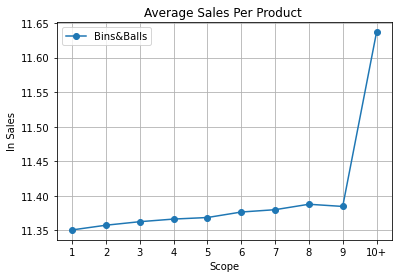

In [32]:
# Plot l_sales and lnSales_bb with nprod as x-axis
plt.plot(agg_df2['nprod'], agg_df2['lnSales_bb'], label='Bins&Balls', marker='o')

plt.xlabel('Scope')
plt.ylabel('ln Sales')


plt.title('Average Sales Per Product ')
plt.legend()
plt.grid(True)

# Determine the range for x-axis ticks based on your data
max_nprod = max(subset1['nprod'].max(), subset2['nprod'].max())
xticks = range(1, int(max_nprod) + 1)

# Set x-axis ticks to be centered at integers 1, 2, 3, 4, ...
plt.xticks(ticks=xticks)

# Replace the last tick label with '10+' if applicable
xtick_labels = [str(tick) for tick in xticks]
if xtick_labels[-1] == '10':  # Only replace if the last label is '10'
    xtick_labels[-1] = '10+'
plt.xticks(ticks=xticks, labels=xtick_labels)

# Save the plot to a PDF file
path = r'..\Includes-python'
plt.savefig(path+'\AppendixFig15.pdf', format='pdf')

plt.show()